#Welcome!

#Table of Contents
## 1. Introduction
## 2. Setting up Packages and Data
## 3. Exploring Data
###_ 3a _ Data Structure
###_ 3b _ Overall Transcriptomics
## 4. Glial Transcriptomics
## 5. Adding Morphlogical Insights to the mix
###_ 5a _ Preparing Training Set
###_ 5b _ Training Model
###_ 5c _ Making Predictions
###_ 5d _ Summarize Morphological Insights
## 6. Conclusion




#1. Introduction

**This notebook will demonstrate a strategy for adding ML-powered morphological classification to spot transcriptomic data.**


The data comes from a publicly available histology slide with three stains and spot transcriptomics via the Visium platform. The slide is a mouse brain tissue section stained with DAPI (specific to DNA), anti-NEUN (specific to neurons), and anti-GFAP (specific to Glial cells).

I will generate some example "phalloidin stain" data to show how a CNN can be trained to predicted cytoskeletal morphology classes. This will supplement the transcriptomic data by uncovering differences in small morphological features across a large histo slide. This approach is much faster than a researcher painstakingly combing through a slide because the researcher only needs to find a few examples of each morphology. The approach is also more flexible and robust than a direct quantification based on a specific gemotric definition of each cytoskeletal morphology class.


For this example, let's say that this slide is from a murine model of Alzheimer's and we are particularly interested in glial cells.
(some background information for the curious: https://pubmed.ncbi.nlm.nih.gov/26825092/)





-------------------------------------------------------------------------- Notes on the data used in this notebook -----------------------------------------------------------------------------------


The Visium data is available for convenient loading as described in this tutorial
https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_visium_fluo.html
The raw transcriptomic data has been pre-processed (normalized and clustered), and the clusters have been given descriptive labels.
We will proceed with our own transcriptomic analysis for the glial cells alone. The addition of morphological insight is completely new from this notebook and not from any tutorial.

It is generally helpful to use the yaml file provided by the tutorial, but their setup seemd to disagree with my setup. You may need to troubleshoot a bit before accessing the data with the squidpy command.

The other files from the github repo (TODO) can be dragged and dropped into the side panel of the colab notebook.

Visium Data storage location for local download if desired: https://www.10xgenomics.com/datasets/adult-mouse-brain-if-stained-ffpe-1-standard-1-3-0

------------------------------------------------------------------------------

## 2. Setting up Packages and Data

To use a yaml file in a colab notebook, put the yaml file in the gdrive of the account running the notebook and load as follows:

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Step 2: Define the path to your YAML file
yaml_file_path = '/content/drive/MyDrive/cellpose_environment.yml'

# # Step 3: Read the YAML file
import yaml
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

# # Step 4: Print the contents of the YAML file
print(config)

Mounted at /content/drive
{'name': 'cellpose', 'channels': ['defaults'], 'dependencies': ['pip', 'python=3.8', {'pip': ['squidpy>=1.1.0', 'cellpose==0.6.2']}]}


You may need to install some packages to your colab instance before importing

In [ ]:
# These instructions are for mac
!pip install anndata
!pip install scanpy
!pip install squidpy
!pip install tifffile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO:

Import the packages you will need

In [ ]:
#The basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from numpy import array
import xarray as xr



#Spatial Bio specific
import anndata as ad
import scanpy as sc
import squidpy as sq


#Image manipulation
from scipy.ndimage import rotate



#For writing and reading in tiffs
import tifffile as tiff
from PIL import Image
import glob



#ML specific
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import h5py
import leidenalg
import igraph as ig



#Help with some heavy lifting
import multiprocessing
from concurrent.futures import ThreadPoolExecutor


# # sc.logging.print_header()
# # print(f"squidpy=={sq.__version__}")

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text

Set random seed for reproducibility

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Read in the data from the public demo

In [ ]:
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

In [ ]:
#Or, if you've downloaded the anndata object locally, you can read it in like this
# adata = ad.read_h5ad('path_to_your_anndata_file.h5ad')

#3. Exploring Data

#3a. Data Structure

Notice the structure of the annotated data object.
The individual observations are the 704 transcriptomic spots, and there are many variables due to each gene in the panel being quantified per spot.
There are also annotations on top of this summarizing the genetic info and doing some initial clustering already.
The corresponding image is in a container which the squidpy package can reference.

In [ ]:
adata

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Notice the appearance of one observation in the dataset

In [ ]:
# Specify the index of an observation to examine
obs_index = 0

# Access the observation data
obs_values = adata.obs.iloc[obs_index]
print(obs_values)

in_tissue                               1
array_row                              35
array_col                              79
n_genes_by_counts                    3808
log1p_n_genes_by_counts          8.245122
total_counts                       9285.0
log1p_total_counts               9.136263
pct_counts_in_top_50_genes      23.155627
pct_counts_in_top_100_genes     28.723748
pct_counts_in_top_200_genes     36.241249
pct_counts_in_top_500_genes     49.929995
total_counts_MT                       0.0
log1p_total_counts_MT                 0.0
pct_counts_MT                         0.0
n_counts                           9285.0
leiden                                  3
cluster                        Thalamus_1
Name: AAACGAGACGGTTGAT-1, dtype: object


Examine the histology slide, one channel at a time.
Recall that Channel 0 is DAPI (specific to DNA), Channel 1 is anti-NEUN (specific to neurons), and Channel 2 is anti-GFAP (specific to Glial cells).


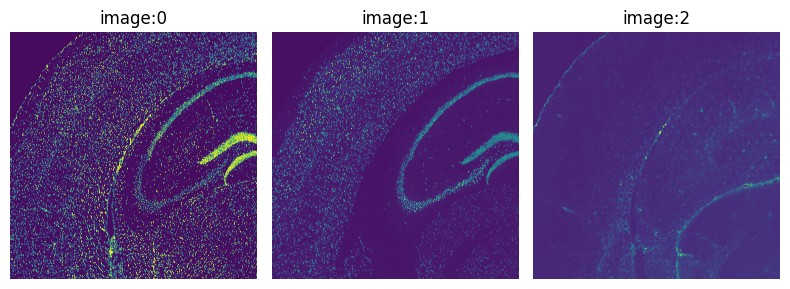

In [ ]:
img.show(channelwise=True)
#add color bar

# 3b. Overall transcriptomics

Examine the transcriptome-wide clustering results for the entire slide, conveniently labelled with descriptive names correlating to each region of the brain. The clustering is based solely on the transcriptomic data, however
these clusters were previously labelled with descriptive names by the Visium scientists who established this public dataset

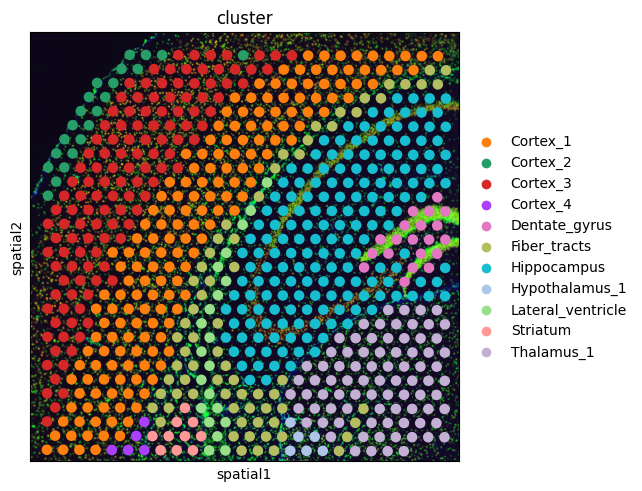

In [ ]:
sq.pl.spatial_scatter(adata, color="cluster")

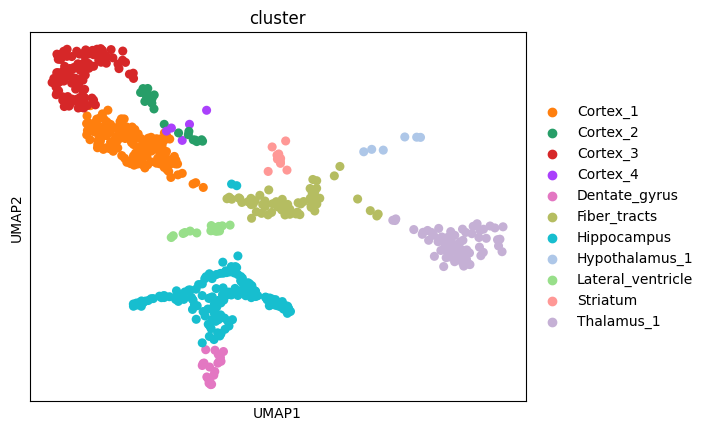

In [ ]:
# Plot the UMAP to obseve cluster separation
sc.pl.umap(adata, color="cluster")

#4. Glial Cell Transcriptomics

The glial cells are those that are bright in channel 2.
Let's zero in on them - we will segment the image, calculate the brightness for channel 2 per segmented region of interest, and calculate the average ROI brightness for each spot. Finally, we will select only those spots bright in Channel 2.

The squidpy package is very powerful for this task.

In [ ]:


#Segment the entire image based on DAPI
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)


In [ ]:
# define image layer to use for calculating the features (ie, the segmentation mask we just made)
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}

# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)

  0%|          | 0/704 [00:00<?, ?/s]

Plot the results of the brightness calculation.

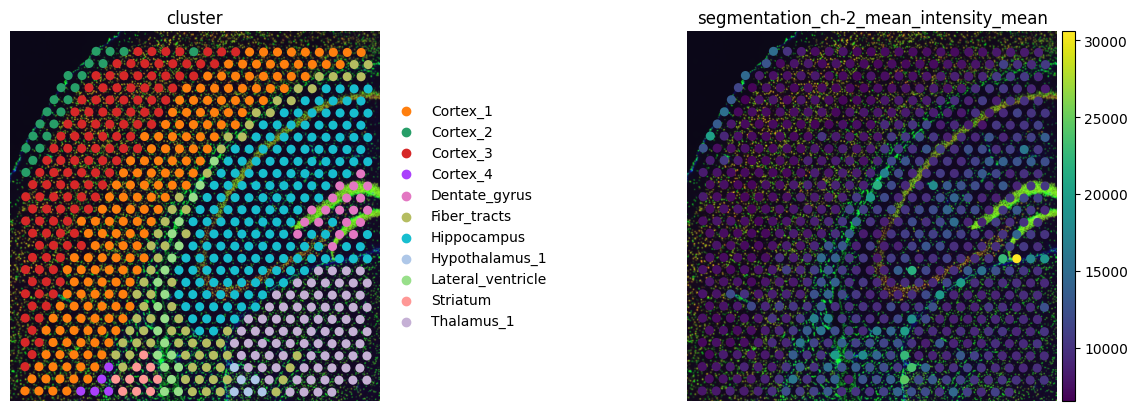

In [ ]:
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "cluster",
        "segmentation_ch-2_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,

)


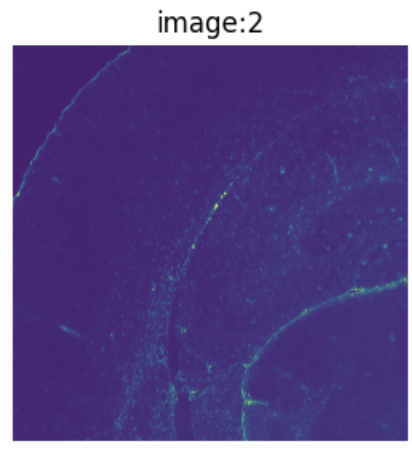

Comparing these results to the image of Channel 2 alone (from step 3a), we see that a mean spot brightness above 12000 correlates well with a glial stain positive area.

So, let's threshold above channel 2 mean spot brightness 12000 to sub-cluster the glial cells.

Also, one notices some apparently positive areas near the left of the image that don't seem to match the shape of the tissue. (The short, nearly horizontal lines.) Are these imaging artifacts?

In [ ]:

#First, simply obtain the subset

# Create a copy of the AnnData object
adata_copy = adata.copy()

# Access the 'features_segmentation' layer
features_segmentation = adata_copy.obsm['features_segmentation']

# Convert to DataFrame for easier manipulation
features_df = pd.DataFrame(features_segmentation, index=adata_copy.obs.index)

# Access the desired column (assuming column 7 corresponds to "segmentation_ch-2_mean_intensity_mean")
channel_2_brightness = features_df.iloc[:, 7]

# Add the channel 2 brightness as a new column in the .obs attribute
adata_copy.obs['channel_2_brightness'] = channel_2_brightness

# Define the threshold value
brightness_threshold = 12000

# Subset the AnnData object for observations with channel 2 brightness above the threshold
subset_adata = adata_copy[adata_copy.obs['channel_2_brightness'] > brightness_threshold]

# Check the subset length
print(len(subset_adata))

105


Plot the results for this subset

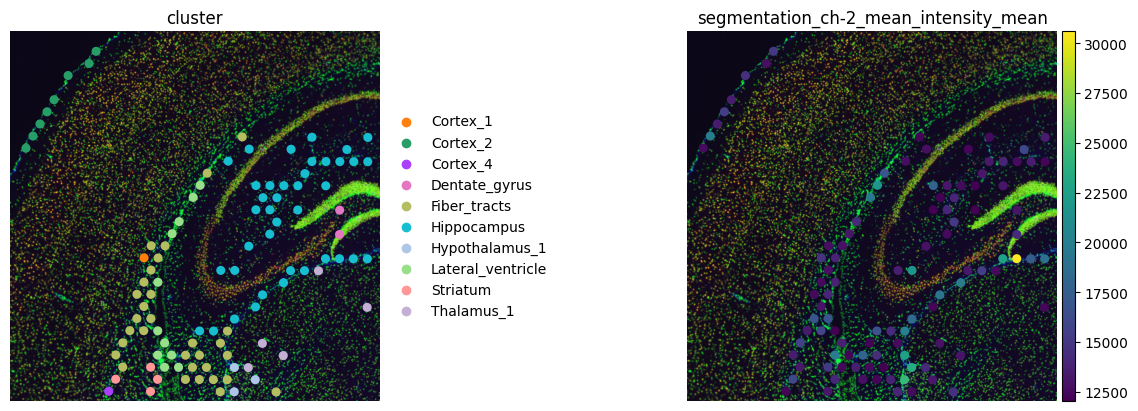

In [ ]:

sq.pl.spatial_scatter(
    sq.pl.extract(subset_adata, "features_segmentation"),
    color=[
        "cluster",
        "segmentation_ch-2_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

Interesting! We see several distinct populations of glial cells.
If we re-do the transcriptomic analysis on only glial-positive cells, does a different clustering pattern emerge?

We will use the same approach that was used for the initial clustering and check silhouette scores to assess the efficacy or the clustering.

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


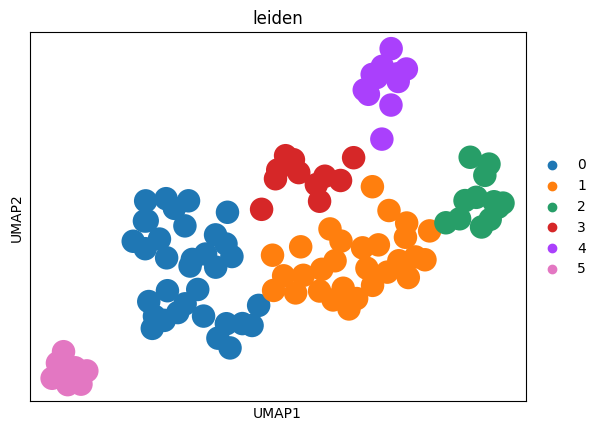

In [ ]:

#Let's explore

# Create a copy of the subset for safety
subset_adata2 = subset_adata.copy()

# Normalize the data
sc.pp.normalize_total(subset_adata2, target_sum=1e4)
sc.pp.log1p(subset_adata2) #interesting - squidpy knows this has already been done and does not repeat the operation!
#Result is the same whether this is commented out or not.

# Find highly variable genes
sc.pp.highly_variable_genes(subset_adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
subset_adata3 = subset_adata2[:, subset_adata2.var.highly_variable]

# Scale the data
sc.pp.scale(subset_adata3, max_value=10)

# Compute the neighborhood graph
sc.pp.neighbors(subset_adata3, n_neighbors=10, n_pcs=40)

# Run the Leiden algorithm
sc.tl.leiden(subset_adata3, resolution=0.6)

# Alternatively, you can use the Louvain algorithm
# sc.tl.louvain(subset_adata, resolution=0.5)

# Compute UMAP for visualization
sc.tl.umap(subset_adata3)

# Plot the UMAP with clusters
sc.pl.umap(subset_adata3, color=['leiden'])  # Or replace 'leiden' with 'louvain' if using Louvain


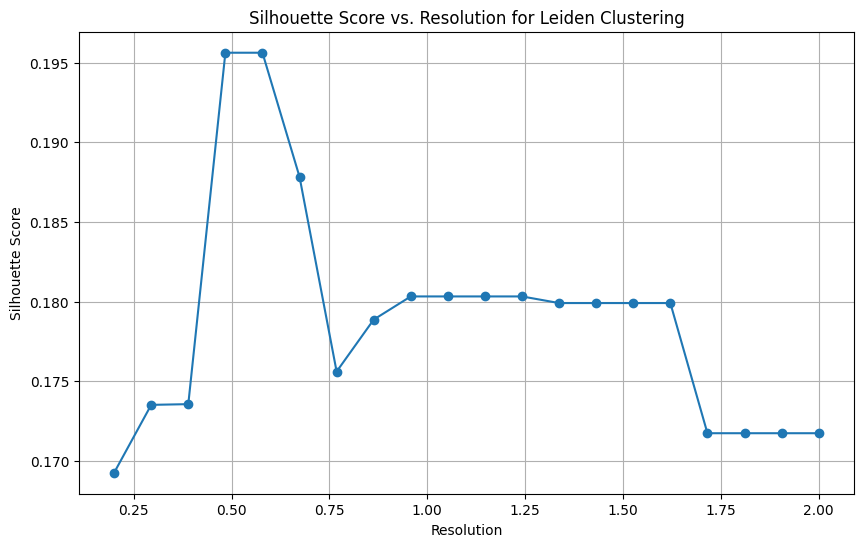

In [ ]:
#Some of those seem pretty close. Does the clustering set up we used result in the best separation?
#Let's try tuning an important clustering hyperparameter to check

# Define a range of resolution values
resolution_values = np.linspace( 0.2, 2.0, 20)

# Initialize a list to store silhouette scores
silhouette_scores = []

for resolution in resolution_values:
    # Run Leiden clustering with the current resolution
    sc.tl.leiden(subset_adata3, resolution=resolution, key_added=f'leiden_{resolution:.2f}')

    # Compute the silhouette score
    score = silhouette_score(subset_adata3.obsm['X_pca'], subset_adata3.obs[f'leiden_{resolution:.2f}'])
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(resolution_values, silhouette_scores, marker='o')
plt.xlabel('Resolution')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Resolution for Leiden Clustering')
plt.grid(True)
plt.show()

#Discussion of the silhouette score
A max sillhouette score of near 0.2 is pretty low, but at least it isn't negative. (Silhouette ranges from -1 to 1 with below zero indicating significant overlap)

If the cluster IDs seem to correlate with spatial information, our decision to subcluster the glial cells based on transcriptomic data will be somewhat supported despite the fairly low silhouette score.

Perhaps the morphological data will give us better cluster separation later on!

Let's plot the new clusters on top of the histo slide to understand the relationship between the subclusters and the overall tissue.

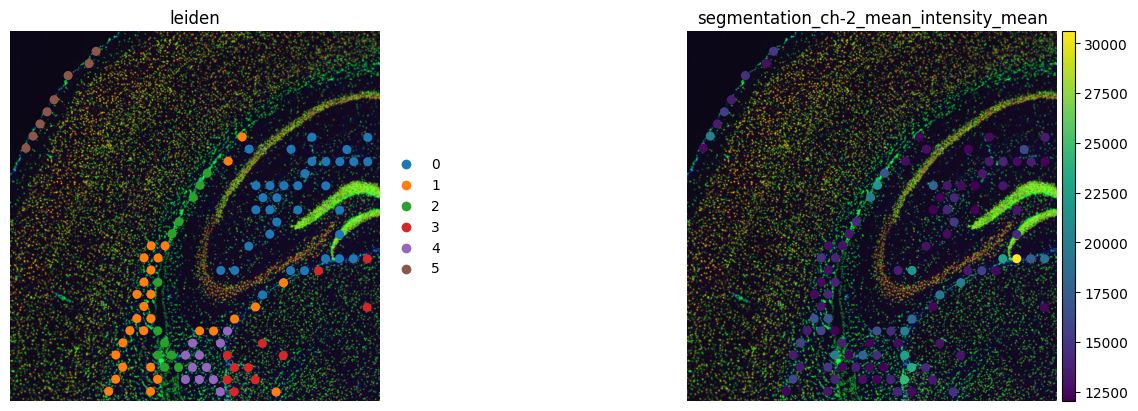

In [ ]:


# Remove the existing color palette for 'leiden' clusters
if 'leiden_colors' in subset_adata3.uns:
    subset_adata3.uns.pop('leiden_colors')


# Extract the segmentation features from the subset AnnData object
extracted_features = sq.pl.extract(subset_adata3, "features_segmentation")

# Plot the results and visualize the clusters
sq.pl.spatial_scatter(
    extracted_features,
    color=[
        "leiden",  # or 'louvain' depending on which clustering method you used
        "segmentation_ch-2_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

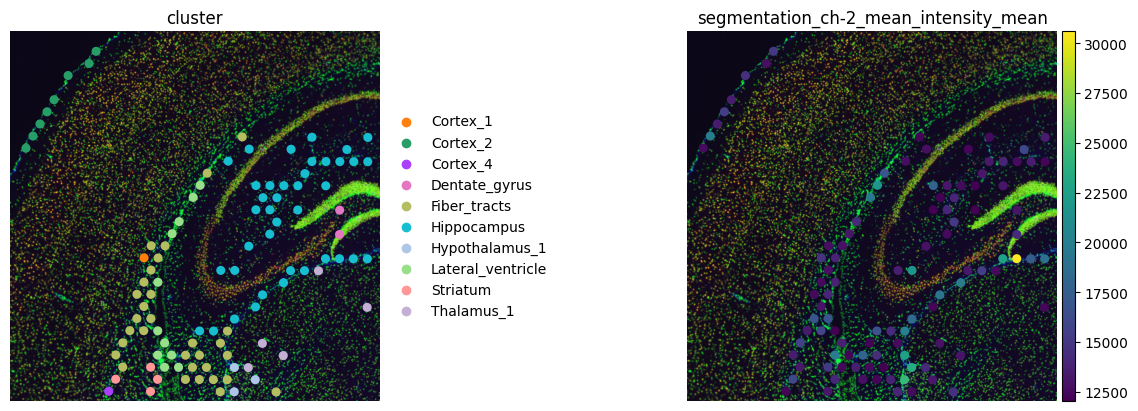

In [ ]:
#And compare these new clusters to the original clusters
sq.pl.spatial_scatter(
    sq.pl.extract(subset_adata, "features_segmentation"),
    color=[
        "cluster",
        "segmentation_ch-2_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

This did result in some changes to the clustering space -

Firstly, the apparent artifacts in Cotex 3/1 have been removed via the brightness threshold.

Overall, the number of clusters has reduced - a few spots which were initially clustered separately are actually placed together when only glial-positive areas are focused upon.

We have honed in a bit on better understanding differences in glial cell activity, but mostly the clusters are still matching the initial tissue-wide characterization. This is comforting in the sense that it at least matches common sense, but is unfortunate in the sense that it doesn't offer much more insight than simply labelling glial cells with their place in the tissue.

What are the key genes resulting in this new subclustering?

categories: 0, 1, 2, etc.
var_group_labels: 5


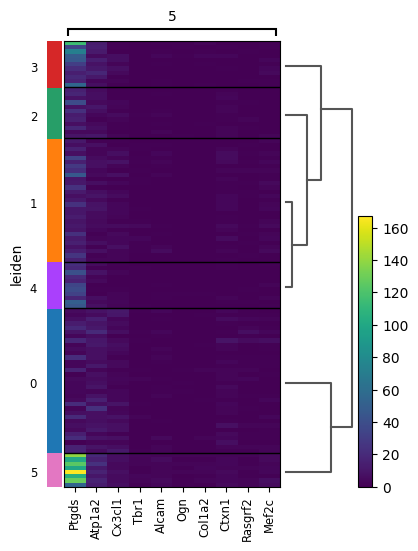

In [ ]:
sc.tl.rank_genes_groups(subset_adata3, "leiden", method="t-test")
sc.pl.rank_genes_groups_heatmap(subset_adata3, groups="5", n_genes=10, groupby="leiden")
#This codeblock does not know that we already log normalized this subset, so please ignore the warning

How does this same clustering approach look if we kick out Ptgds for better visualization?

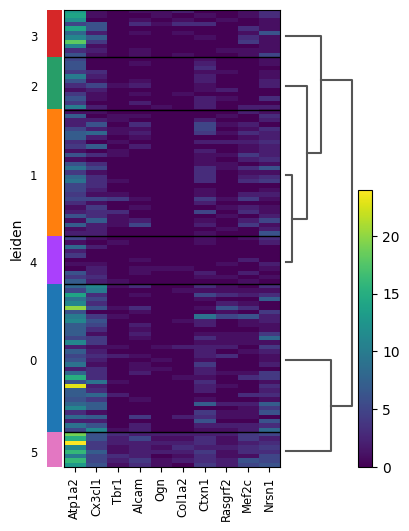

In [ ]:
# Rank genes and skip the first most important gene (e.g., "Ptgds")
sc.tl.rank_genes_groups(subset_adata3, "leiden", method="t-test")

# Get the ranked genes for the specific group (5 in this example)
ranked_genes = subset_adata3.uns['rank_genes_groups']['names']['5']
ranked_genes_scores = subset_adata3.uns['rank_genes_groups']['scores']['5']

# Filter out "Ptgds" and get the next top 10 genes
filtered_genes = [gene for gene in ranked_genes if gene != 'Ptgds']
filtered_scores = [ranked_genes_scores[i] for i, gene in enumerate(ranked_genes) if gene != 'Ptgds']

# Use the filtered genes for the heatmap
sc.pl.rank_genes_groups_heatmap(subset_adata3, var_names=filtered_genes[:10], groupby="leiden")

**Two genes seem significant here. Some notes on them follow below - it is not necessary to understand these notes to proceed with the notebook.**

**I don't know much about ptgds, but here is a quick summary.**






The PTGDS gene, or prostaglandin D2 synthase gene, is a gene that is expressed in the brain and is involved in the production of prostaglandin D2 (PGD2). PGD2 is a neuromodulator that affects the central nervous system.


Function: Catalyzes the conversion of PGH2 to PGD2, Inhibits platelet aggregation, Involved in smooth muscle contraction and relaxation, and May regulate non-rapid eye movement sleep.


Associated conditions: Intracranial hypotension, Normal pressure hydrocephalus, and Male pattern baldness.


Other functions: Involved in lipid metabolism, Involved in tumorigenesis, and Involved in tumor infiltrating immune cells.


Clinical significance:

High expression of PTGDS is associated with poor prognosis in some cancers.

Knockdown of PTGDS can impair cell proliferation, migration, and invasion.

Knockdown of PTGDS can promote cell apoptosis.

**Neither do I know much about the second most important gene, Atp1a2, but here is another summary.**







The ATP1A2 gene provides instructions for making the alpha-2 subunit of the Na+/K+ ATPase protein. This protein is found in glial cells of the nervous system, where it helps maintain the normal function of neurons.


Function

The Na+/K+ ATPase protein uses energy from adenosine triphosphate (ATP) to pump sodium ions out of cells and potassium ions into cells.

It also helps regulate the removal of neurotransmitters from the spaces between neurons.


Genetic mutations

Mutations in the ATP1A2 gene are associated with familial hemiplegic migraine (FHM) and sporadic hemiplegic migraine (SHM).

These mutations impair the function of the Na+/K+ ATPase protein, which leads to changes in signaling in the brain.

These changes can cause severe headaches, auras, and other neurological disorders.



Other clinical manifestations of ATP1A2 mutations include:


Epilepsy

Dystonia

Growth retardation

Episodic eye movement abnormalities

Recurrent hemiplegia

Inheritance

ATP1A2 mutations can be inherited or occur as de novo mutations

**This all seems interesting, but the separation is so poor and so driven by so few genes that the squidpy package thought things hadn't been properly log transformed,
and our sillhouette score is pretty low.**


**Can morphology give us another hint about what is going on with these glial cells?**


**Are we able to separate some interesting glial populations based on morphological information?**

#5. Adding Morphlogical Insights to the mix
###_ 5a _ Preparing Training Set


In [ ]:
# Just FYI, let's access the dimensions of the tissue slide image
img_data = img['image']  # Extract image data
height, width = img_data.shape[:2]

print(f'Height: {height}')
print(f'Width: {width}')

Height: 7272
Width: 7272


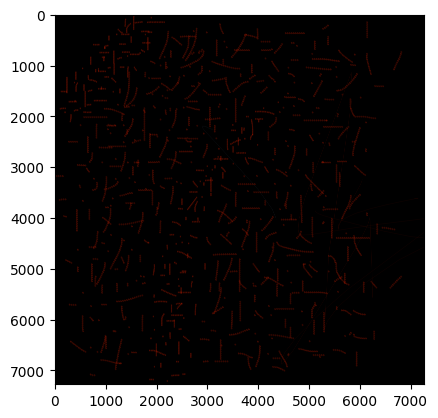

In [ ]:
# I have created a pretend phalloidin stain channel image to match these dimensions
#let's read it in. Drag and drop the file into the colab side panel to run this block succesfully.

# Get tif files list from the data folder
path = '/content/'
image_files = glob.glob(path + "*.tiff")

for file in image_files:
    try:
      im_1 = Image.open(file)
      ar = array(im_1)
    except:
      continue

plt.imshow(ar)

The features are so small that it's difficult to see them at this scale,
but we will continue with putting the array in a tif and zooming in to see more
Let's use this moment to also confirm our save ability - we will need it later

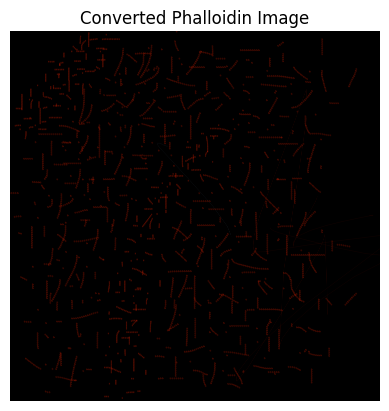

In [ ]:


phalloidin_array = ar

# Convert the NumPy array to a TIFF image
tiff.imwrite('phalloidin_converted.tif', phalloidin_array)

# Verify by reading and displaying the image
converted_image = tiff.imread('phalloidin_converted.tif')


plt.imshow(converted_image, cmap='gray')
plt.title('Converted Phalloidin Image')
plt.axis('off')
plt.show()

Extract a single channel (e.g., the first channel) for gray scale so that we can more easily work with this image and eventually add it to the histo slide.

In [ ]:

single_channel_image = converted_image[:, :, 0]  # Use the first channel

# Check the shape
print(f"Shape of single_channel_image: {single_channel_image.shape}")


Shape of single_channel_image: (7272, 7272)


We will be able to see the small features better if we break the image into small pieces.

Also, we will use these pieces to create predictions of morphologies one piece at a time.

In [ ]:
# Define the chunk size
# 101 is a prime factor of 7272 (which means the chunks will fit in a nice, orderly fashion) and is also a resonable size to capture a
#single cell or a small group of cells.
# The size could be adjusted if we were looking for a very small morphology, or a very large multi cell pattern.
# Also, several chunks (about 10) will fit in each spot, so that gives us a decent pool to average from to get an idea of the overall
#morphology within a spot (thus avoiding the large amount of noise we would get from just one morphological prediction per spot.)

chunk_size = 101

# List to store the chunks
chunks = []
nonzero_chunks = []

# Break the image into 101x101 chunks
for i in range(0, single_channel_image.shape[0], chunk_size):
    for j in range(0, single_channel_image.shape[1], chunk_size):
        chunk = single_channel_image[i:i + chunk_size, j:j + chunk_size]
        chunks.append(chunk)
        #make a note of how many image chunks are not filled with entirely blank space, so that we can find them more easily later
        #If a chunk is entirely empty, we expect the first pixel to match all pixels in that chunk
        if np.any(chunk != chunk.ravel()[0]):
          nonzero_chunks.append(chunk)
        else:
          continue

# Verify the number of chunks
print(f"Number of chunks: {len(chunks)}")
print(f"Number of nonzero chunks: {len(nonzero_chunks)}")

Number of chunks: 5184
Number of nonzero chunks: 2401


In [ ]:
## This code is just for grabbing an example single cell from the histo slide for the powerpoint presentation.

# img_array = img.data['image'].values.squeeze()  # Ensure it's a 3D array (height, width, channels) by getting rid of slice dimension

# # Normalize pixel values to the range [0, 255]
# img_array = np.clip(img_array, 0, 65535)  # Assuming original data range is [0, 65535]
# img_array = (img_array / 65535) * 255
# img_array = img_array.astype(np.uint8)

# # Define the size of the cropped region
# crop_size = 101

# # Generate random coordinates for the top-left corner of the crop
# max_x = img_array.shape[1] - crop_size
# max_y = img_array.shape[0] - crop_size
# x = random.randint(0, max_x)
# y = random.randint(0, max_y)

# # Crop the image using numpy slicing
# cropped_image = img_array[y:y + crop_size, x:x + crop_size, :]

# # Display the cropped image using matplotlib
# plt.figure(figsize=(5, 5))
# plt.imshow(cropped_image)  # Remove cmap to display color image
# plt.title(f'Random 101x101 Crop at ({x}, {y})')
# plt.axis('off')
# plt.show()

# # Display the cropped image for each channel separately
# channels = ['Red', 'Green', 'Blue']
# for i, channel in enumerate(channels):
#     channel_image = cropped_image[:, :, i]

#     plt.figure(figsize=(5, 5))
#     plt.imshow(channel_image, cmap='gray')  # Use grayscale colormap to display single channel
#     plt.title(f'Random 101x101 {channel} Channel Crop at ({x}, {y})')
#     plt.axis('off')
#     plt.show()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
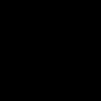

In [ ]:
#Examine chunks
#I expect this one to be empty since the tissue does not extend to the top left corner of the slide
chunks[0]

array([[0, 0, 0, ..., 7, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
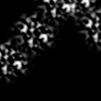

In [ ]:
#Examine chunks
#After carefully reviewing the overall image, our pretend scientist says this chunks is representative of a typical cytoskeletal morphology
nonzero_chunks[1540]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [20, 28, 34, ...,  0,  0,  0],
       [ 3,  0,  0, ...,  0,  0,  0],
       [ 3,  0,  0, ...,  0,  0,  0]], dtype=uint8)
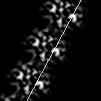

In [ ]:
#There is an imaging artifact in the form of a very thin line going across the stained area for this example.
nonzero_chunks[1330]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [133, 123, 112, ...,  70,  71,  73],
       [126, 120, 122, ...,  58,  50,  51],
       [ 98,  98, 103, ...,  71,  56,  49]], dtype=uint8)
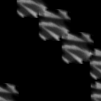

In [ ]:
#Examine chunks
#Our pretend scientist says this is an unusual cytoskeletal morphology and worth invesetigating.
nonzero_chunks[31]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0, 25, 74, ...,  0,  0,  0],
       [ 0,  0, 15, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)
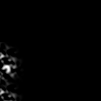

In [ ]:
nonzero_chunks[1113]

Now we can see that the small red lines we initially saw in the phalloidin image are actually made of two different textures.

This is a representation of different cytoskeletal morphologies

In [ ]:

#I'm going to call these textures line and circle, or linear and nonlinear, as a nickname

#Let's collect some examples of each

# Example indices
line_examples_indices = [10,20,31,80,151,375,738,740,850,880,990,992,1188,1189,1190,1260,1263,1264,1570,1600,1630,1787,1790,2391,2395]
circle_examples_indices = [157,367,730,940,970,1100,1230,1250,1330,1370,1382,1420,1460,1540,1550,1610,1760,2080,2255,2300]
empty_examples_indices = [0, 1, 2, 3, 4]

# Select the desired chunks
line_examples = [nonzero_chunks[i] for i in line_examples_indices]
nonline_examples = [nonzero_chunks[i] for i in circle_examples_indices]+[chunks[i] for i in empty_examples_indices]

# Verify the selection
print(f"Number of linear selected chunks: {len(line_examples)}")
print(f"Number of nonlinear selected chunks: {len(nonline_examples)}")

Number of linear selected chunks: 25
Number of nonlinear selected chunks: 25


Take a look at examples of each morphology.

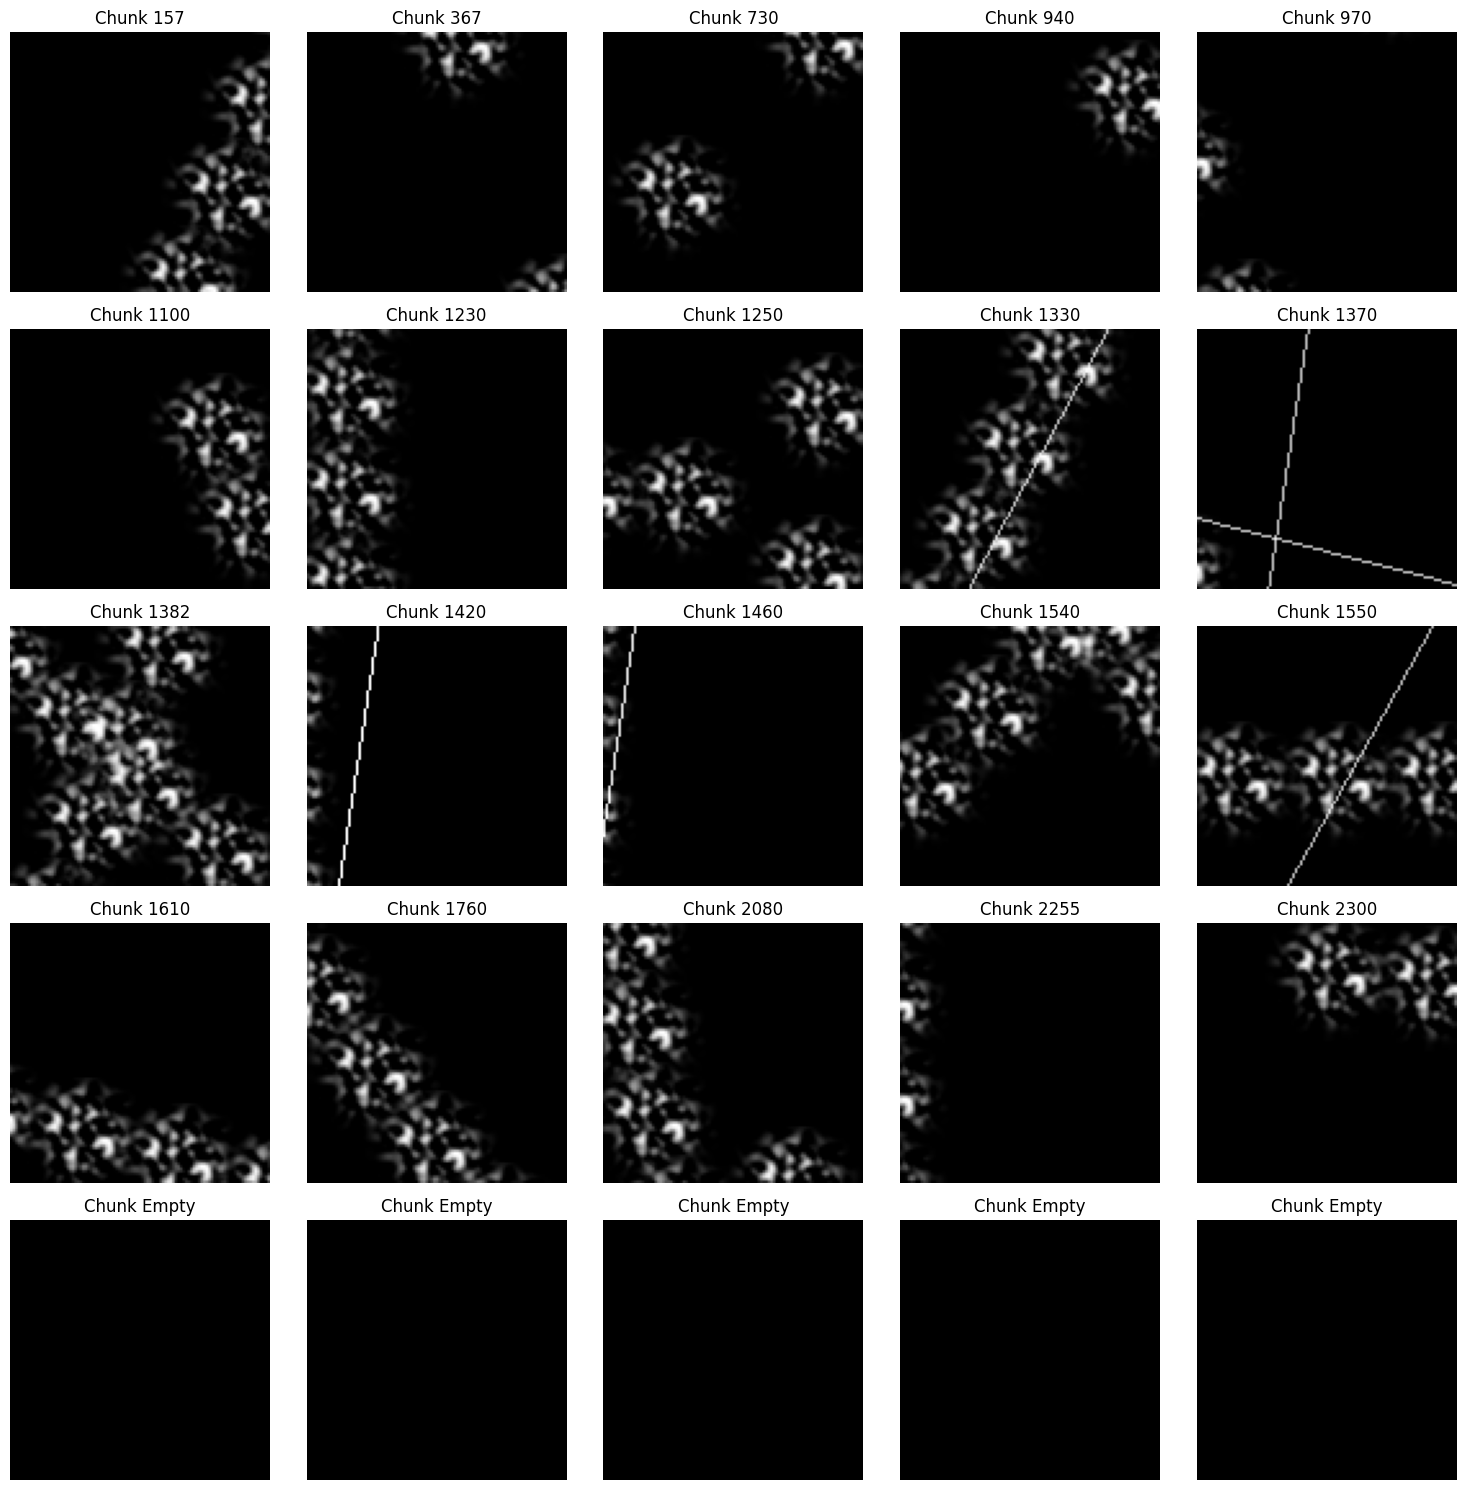

In [ ]:
# Examine nonlinear examples

# Determine the number of rows and columns for the grid
num_chunks = len(nonline_examples)
num_cols = 5  # Set the number of columns you want in the grid
num_rows = (num_chunks // num_cols) + (num_chunks % num_cols > 0)

# Create a figure and axes to display the chunks
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Loop through the selected chunks and plot them
for i, ax in enumerate(axes.flat):
    if i < num_chunks:
        chunk = nonline_examples[i]  # Use the chunk directly from line_examples
        ax.imshow(chunk, cmap='gray')
        if i<20:
          ax.set_title(f'Chunk {circle_examples_indices[i]}')  # Update to display the original index
        else:
          ax.set_title('Chunk Empty')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any extra subplots

plt.tight_layout()
plt.show()

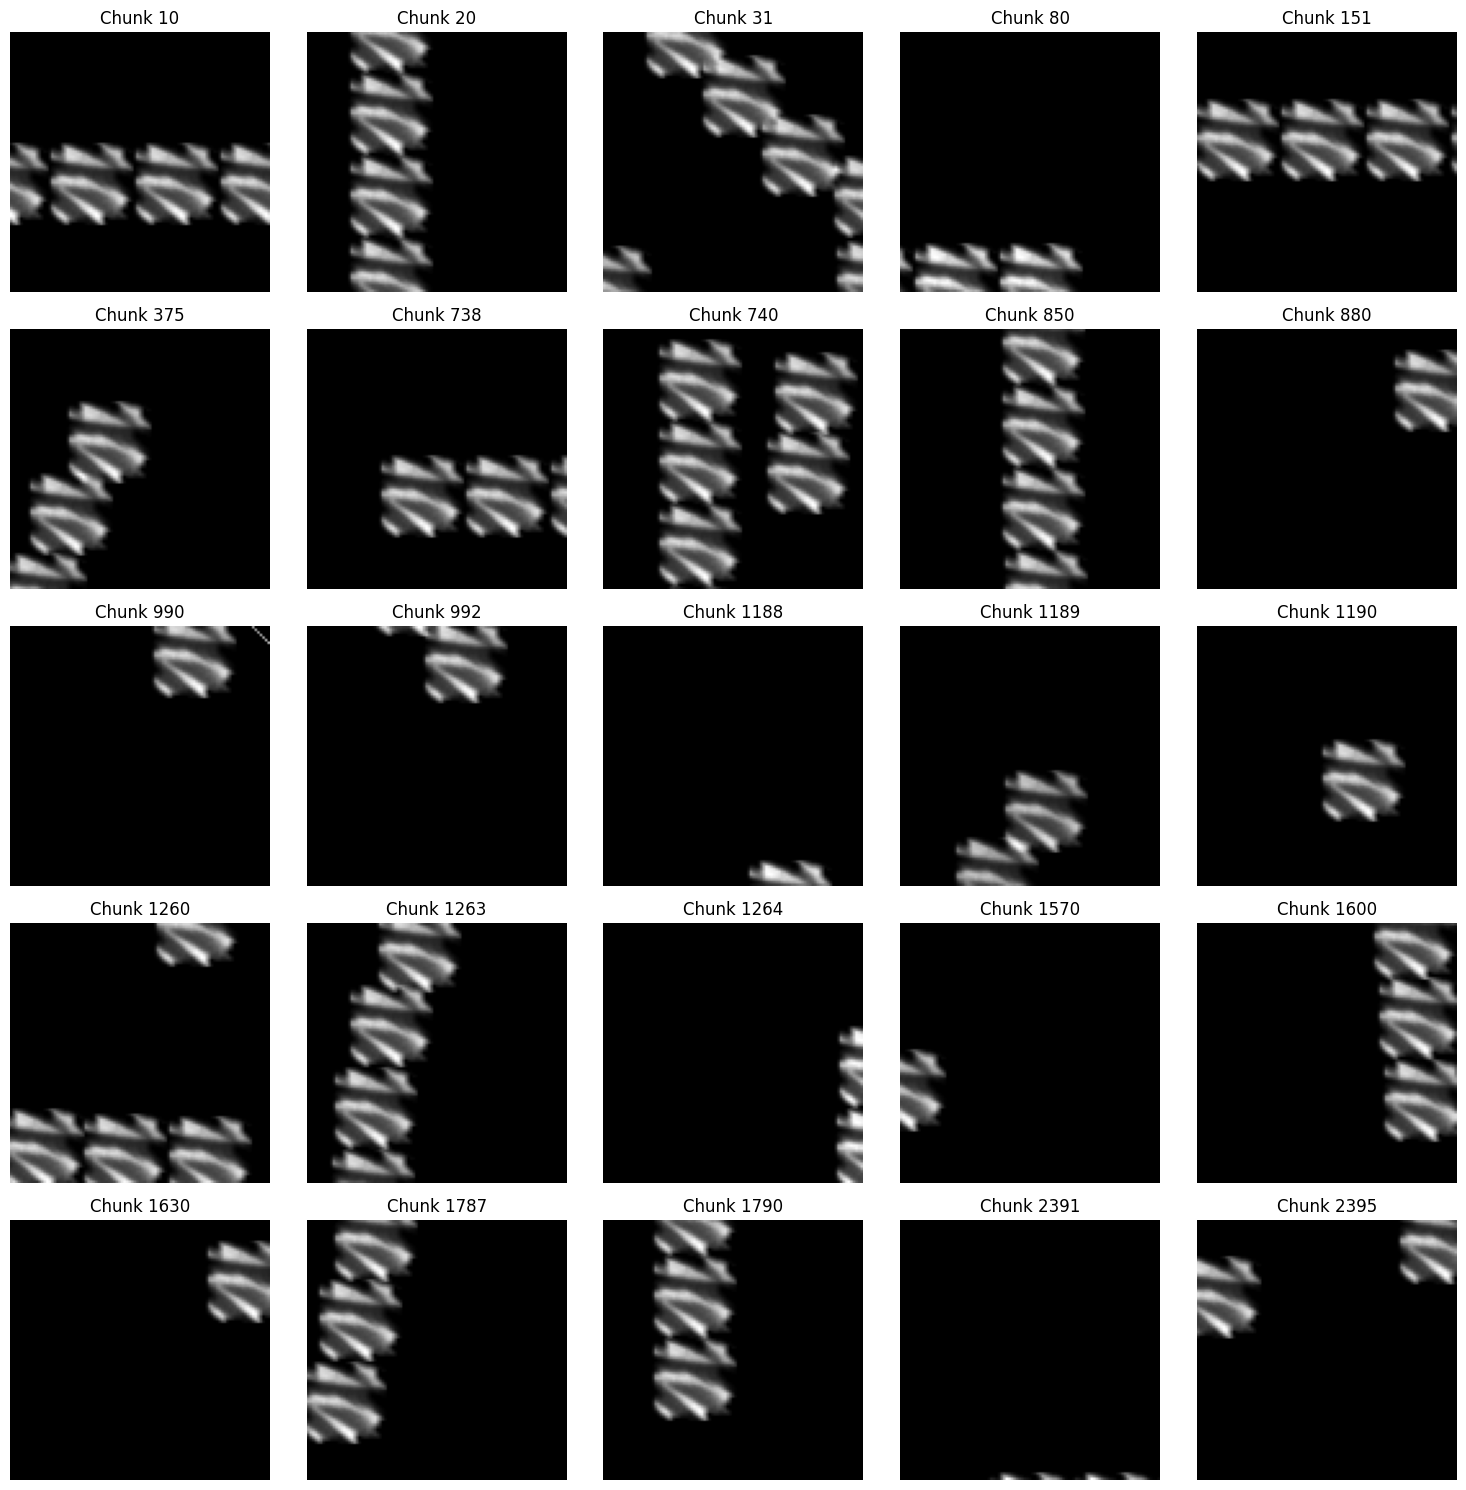

In [ ]:
# Examine linear examples

# Determine the number of rows and columns for the grid
num_chunks = len(line_examples)
num_cols = 5  # Set the number of columns you want in the grid
num_rows = (num_chunks // num_cols) + (num_chunks % num_cols > 0)

# Create a figure and axes to display the chunks
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Loop through the selected chunks and plot them
for i, ax in enumerate(axes.flat):
    if i < num_chunks:
        chunk = line_examples[i]  # Use the chunk directly from line_examples
        ax.imshow(chunk, cmap='gray')
        ax.set_title(f'Chunk {line_examples_indices[i]}')  # Update to display the original index
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any extra subplots

plt.tight_layout()
plt.show()

We want to train a model to predict the presence of the interesting linear morphology across the entire image.

To make a training set from the examples kindly collected by our scientist, we should rotate the images somewhat randomly so that the model doesn't memorize something actually present in the image.
I say "somewhat randomly", because we don't want the angle to be 0 or 360, and we don't want the rotation to result in an accidental empty image for the cases where the image is not empty.

We expect a report that the last five images will be empty, since that's where I put the empty chunks.

In [ ]:
# Example data
linear_examples = line_examples
nonlinear_examples = nonline_examples

# Function to rotate images with some limited retry logic, and angle storage for posterity and agressive publisher inquiries
def rotate_examples_with_angles(examples, angles, max_retries=10):
    rotated = []
    used_angles = []
    for idx, img in enumerate(examples):
        for attempt in range(max_retries):
            angle = random.choice(angles)
            rotated_img = rotate(img, angle, reshape=False)
            if np.any(rotated_img):  # Check if the rotated image is not empty
                rotated.append(rotated_img)
                used_angles.append(angle)
                break
                #if you can't find a non-empty angle to use, just rotate by only one degree and append
        else:
            print(f"Failed to find a non-empty rotation for example {idx} after {max_retries} tries")
            rotated_img = rotate(img, 1, reshape=False)
            rotated.append(rotated_img)
            used_angles.append(1)  # Add a placeholder for the failed example
    return rotated, used_angles

# Rotate linear examples with any angle between 1 and 359 and store angles
rotated_linear_examples, angles_line = rotate_examples_with_angles(linear_examples, range(1, 360))

# Rotate nonlinear examples with any angle between 1 and 359 and store angles
rotated_nonlinear_examples, angles_nonline = rotate_examples_with_angles(nonlinear_examples, range(1, 360))

# Print shapes to verify
print(f"Rotated linear examples shape: {np.array(rotated_linear_examples).shape}")
print(f"Rotated nonlinear examples shape: {np.array(rotated_nonlinear_examples).shape}")



Failed to find a non-empty rotation for example 20 after 10 tries
Failed to find a non-empty rotation for example 21 after 10 tries
Failed to find a non-empty rotation for example 22 after 10 tries
Failed to find a non-empty rotation for example 23 after 10 tries
Failed to find a non-empty rotation for example 24 after 10 tries
Rotated linear examples shape: (25, 101, 101)
Rotated nonlinear examples shape: (25, 101, 101)


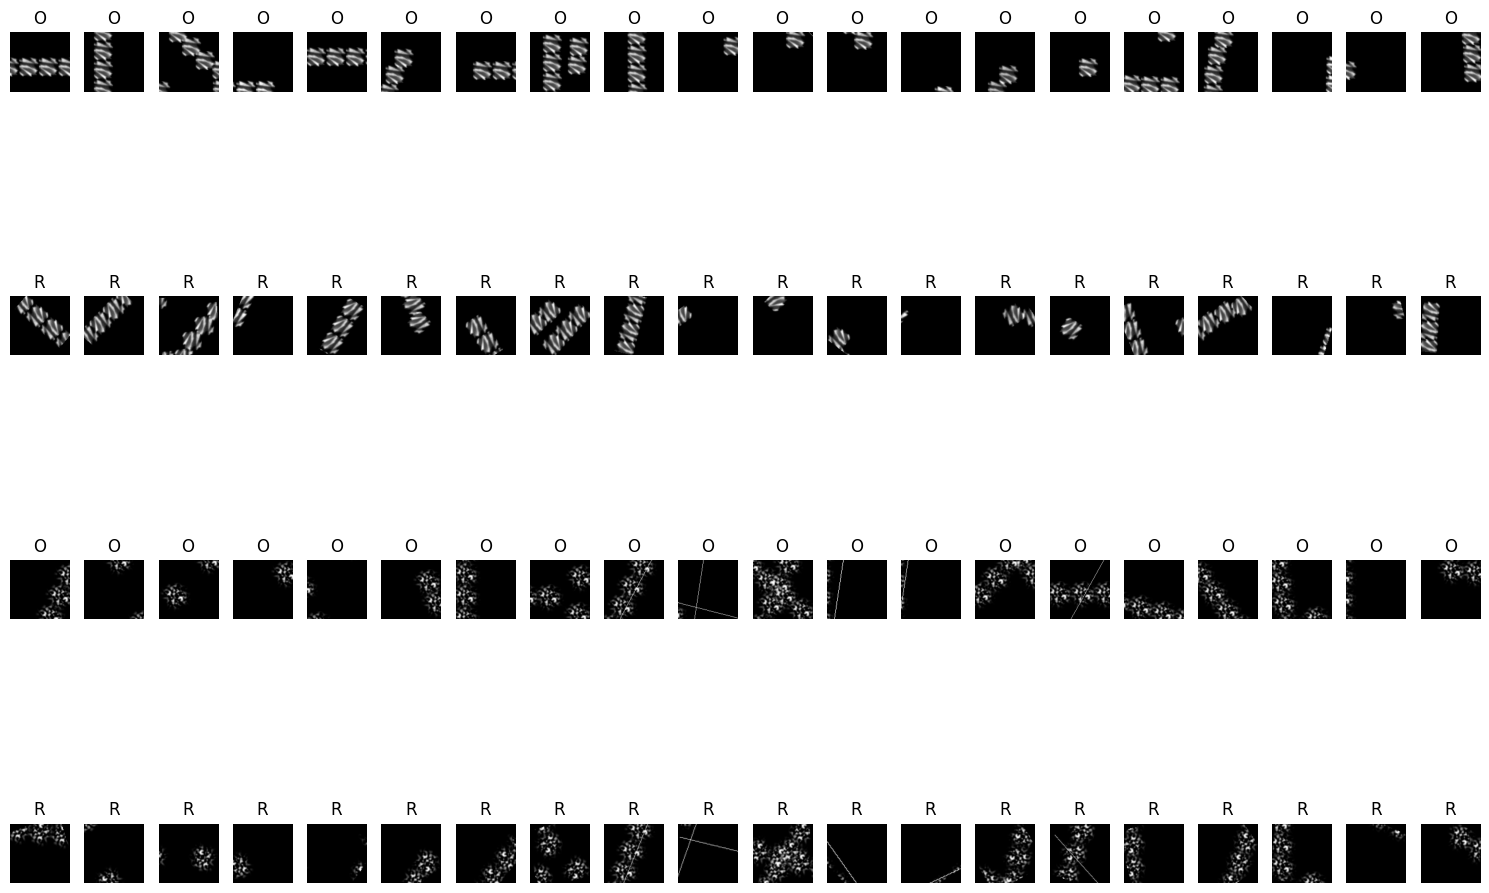

In [ ]:
# If you're feeling nervous, you can cerify the rotation by displaying a few examples
num_examples_to_display = 20

fig, axes = plt.subplots(4, num_examples_to_display, figsize=(15, 12))

# Display line examples
for i in range(num_examples_to_display):
    # Original line example
    axes[0, i].imshow(line_examples[i], cmap='gray')
    axes[0, i].set_title('O')
    axes[0, i].axis('off')

    # Rotated line example
    axes[1, i].imshow(rotated_linear_examples[i], cmap='gray')
    axes[1, i].set_title('R')
    axes[1, i].axis('off')

# Display nonline examples
for i in range(num_examples_to_display):
    # Original nonline example
    axes[2, i].imshow(nonline_examples[i], cmap='gray')
    axes[2, i].set_title('O')
    axes[2, i].axis('off')

    # Rotated nonline example
    axes[3, i].imshow(rotated_nonlinear_examples[i], cmap='gray')
    axes[3, i].set_title('R')
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

Save this training set as HDF5 file so that someone else can reproduce our work from randomly generated objects precisely

In [ ]:
with h5py.File('training_set.h5', 'w') as f:
    f.create_dataset('line_examples', data=np.array(line_examples))
    f.create_dataset('rotated_linear_examples', data=np.array(rotated_linear_examples))
    f.create_dataset('nonline_examples', data=np.array(nonline_examples))
    f.create_dataset('rotated_nonlinear_examples', data=np.array(rotated_nonlinear_examples))
    f.create_dataset('angles_line', data=angles_line)
    f.create_dataset('angles_nonline', data=angles_nonline)

print("Training set saved successfully!")

Training set saved successfully!


In [ ]:
# # Load training set from HDF5 file if you already have it and you're just cruising through the notebook
with h5py.File('training_set.h5', 'r') as f:
    line_examples = list(f['line_examples'])
    rotated_linear_examples = list(f['rotated_linear_examples'])
    nonline_examples = list(f['nonline_examples'])
    rotated_nonlinear_examples = list(f['rotated_nonlinear_examples'])
    angles_line = list(f['angles_line'])
    angles_nonline = list(f['angles_nonline'])

Create labels to go with the example images

In [ ]:
#Initiate arrays of proper size
line_examples_labels = np.ones(len(rotated_linear_examples))  # Label 1 for linear examples
nonline_examples_labels = np.zeros(len(rotated_nonlinear_examples))  # Label 0 for nonlinear examples

# Combine the examples and labels
X_train = np.array(rotated_linear_examples + rotated_nonlinear_examples)
y_train = np.concatenate([line_examples_labels, nonline_examples_labels])

# Shuffle the training set so that the model doesn't memorize anything based on example order
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train_set = y_train[indices]

# Reshape X_train as appropriate for the model to use (add channel dimension for CNN convenience.)
X_train_set = X_train.reshape(-1, 101, 101, 1)

print(f"Shape of X_train: {X_train_set.shape}")  # Should be (number_of_chunks, 101, 101, 1)
print(f"Shape of y_train: {y_train_set.shape}")  # Should be (number_of_chunks,)

Shape of X_train: (50, 101, 101, 1)
Shape of y_train: (50,)


#_ 5b _ Training Model

Try a simple CNN first.
(Too simple, clearly not going to work. This is just to demonstrate a poor model and how it can be improved.)

In [ ]:
#Now we have a training set and labels, so it's time to try a simple model!
def create_simple_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Go ahead and create the model
input_shape = (101, 101, 1)  # Single channel input
model = create_simple_cnn_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 99, 99, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,806,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,862,209 (7.10 MB)

 Trainable params: 1,862,209 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

Apply the simple model

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 1.6003 - val_accuracy: 0.2500 - val_loss: 55.4072
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - accuracy: 0.5625 - loss: 33.3188 - val_accuracy: 0.2500 - val_loss: 18.3366
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 10.4278 - val_accuracy: 0.6250 - val_loss: 1.6772
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step - accuracy: 0.8750 - loss: 0.5527 - val_accuracy: 0.6250 - val_loss: 0.9070
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 1.0433 - val_accuracy: 0.6250 - val_loss: 0.8464
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - accuracy: 0.5625 - loss: 1.1576 - val_accuracy: 0.5000 - val_loss: 0.6738
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - accuracy: 0.7500 - loss: 0.3931 - val_accuracy: 0.5000 - val_loss: 0.6082
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - accuracy: 0.9062 - loss: 0.1706 - val_a

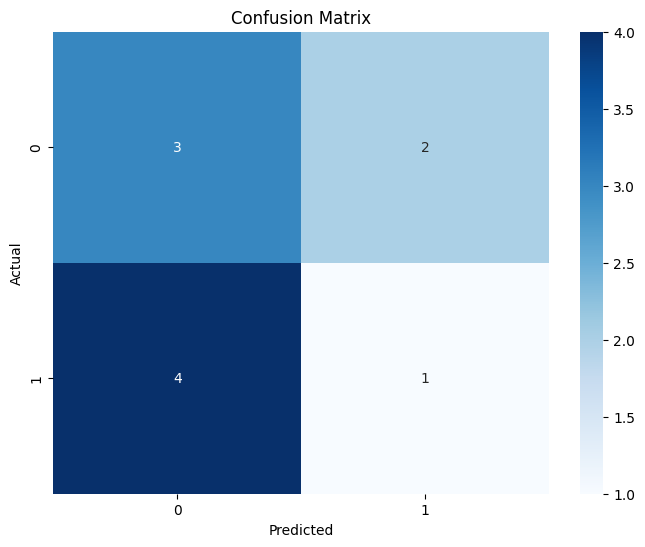

              precision    recall  f1-score   support

         0.0       0.43      0.60      0.50         5
         1.0       0.33      0.20      0.25         5

    accuracy                           0.40        10
   macro avg       0.38      0.40      0.38        10
weighted avg       0.38      0.40      0.38        10



In [ ]:

# Compute class weights with generic code (in case we ever want to increase the number of classes).
# This code is just making sure that we have an equal number of non-linear examples
# and linear examples when we split into validation sets during training

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_set), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weights_dict}")

#Leave out a test set
X_train, X_test, y_train, y_test = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=seed, stratify=y_train_set)

#Here I include some code to visualize the train and test sets, just in case you are curious to see them
# # Determine the number of examples to display based on the smallest set size
# num_examples_to_display = min(20, len(X_train), len(X_test))

# fig, axes = plt.subplots(2, num_examples_to_display, figsize=(15, 12))

# # Display line examples
# for i in range(num_examples_to_display):
#     # Original line example
#     axes[0, i].imshow(X_train[i], cmap='gray')
#     axes[0, i].set_title('train')
#     axes[0, i].axis('off')

#     # Rotated line example
#     axes[1, i].imshow(X_test[i], cmap='gray')
#     axes[1, i].set_title('test')
#     axes[1, i].axis('off')


# plt.tight_layout()
# plt.show()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, class_weight=class_weights_dict)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(class_report)

That doesn't look good! What can we do to improve this model?


Since our training set is relatively small and CNNs are prone to becoming confused by unimportant details, it helps a lot to augment the training set.
We will employ some random manipulation to the images each time the model trains, including these manipulated images along with the normal images in each training set. Things like zoom and shear are important not because they represent what is truly in the data, but because they help CNNs realize the importance of the bigger picture.


We can also add model complexity, since the differences between these texture patterns are fairly complex - they are the same brightness and the same overall size, each generally organized in side by side series, but the details of the networking morphology differ between each class.


Since the model will be more complex and the training set will be larger, we can include more training opportunities (more epochs), but it is important to include early stopping in this case so that we don't accidentally overfit. However, I will be fairly patient with my early stopping cut off, since local minima are easy to get stuck in for this complex case.


We should also use k-fold cross-validation to see if the model is performing well across different train/test splits within each run.


Here's the updated model. Let's see if it does any better!

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 99, 99, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,297,281 (4.95 MB)

 Trainable params: 1,297,281 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - accuracy: 0.5437 - loss: 2.2139 - val_accuracy: 0.4000 - val_loss: 1.5065
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.5375 - loss: 1.7360 - val_accuracy: 0.6000 - val_loss: 0.5677
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.5396 - loss: 0.8511 - val_accuracy: 0.7000 - val_loss: 0.5631
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step - accuracy: 0.7000 - loss: 0.7574 - val_accuracy: 0.8000 - val_loss: 0.5674
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - accuracy: 0.5250 - loss: 1.0723 - val_accuracy: 0.8000 - val_loss: 0.5447
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - accuracy: 0.7104 - loss: 0.5966 - val_accuracy: 0.7000 - val_loss: 0.5268
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.7875 - loss: 0.5731 - val_accuracy: 0.8000 - val_loss: 0.5244
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6667 - loss: 0.6208 - val_accuracy: 0.7000 - val_loss: 0.5354
Epoch 

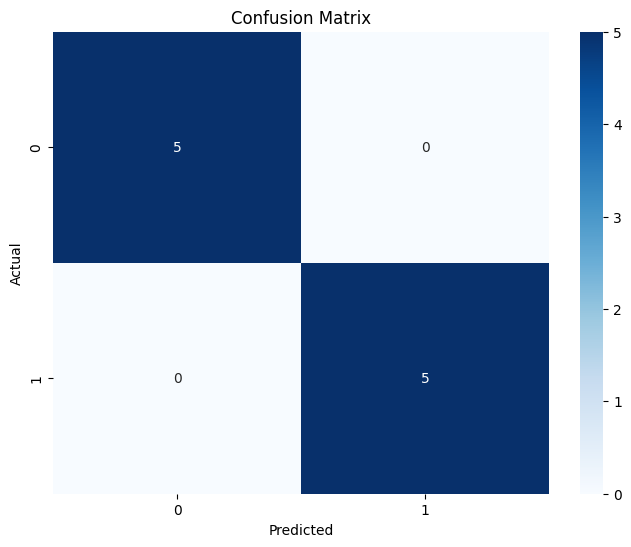

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [ ]:

# Make sure we use the same test set to be fair (seed is the same as before)
X_train, X_test, y_train, y_test = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=seed, stratify=y_train_set)


def create_morecomplex_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
input_shape = (101, 101, 1)
model = create_morecomplex_cnn_model(input_shape)
model.summary()

# Data augmentation with seed for consistency
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Initialize lists to store history
train_losses = []
val_losses = []

# Iterate over each fold
for train_index, val_index in kf.split(X_train_set):
    X_train_fold, X_val_fold = X_train_set[train_index], X_train_set[val_index]
    y_train_fold, y_val_fold = y_train_set[train_index], y_train_set[val_index]

    model = create_morecomplex_cnn_model(input_shape)
    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=32),
                        epochs=50,
                        validation_data=(X_val_fold, y_val_fold),
                        class_weight=class_weights_dict,
                        callbacks=[early_stopping])

    # Append the training and validation loss
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate the model on the validation set for each fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Fold validation accuracy: {val_accuracy}")

# Final evaluation on the test set
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print(f"Final test accuracy: {final_accuracy}")

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(class_report)


Check to see if the model is overfit. If it is overfit, we expect validation loss to rise as training loss falls.

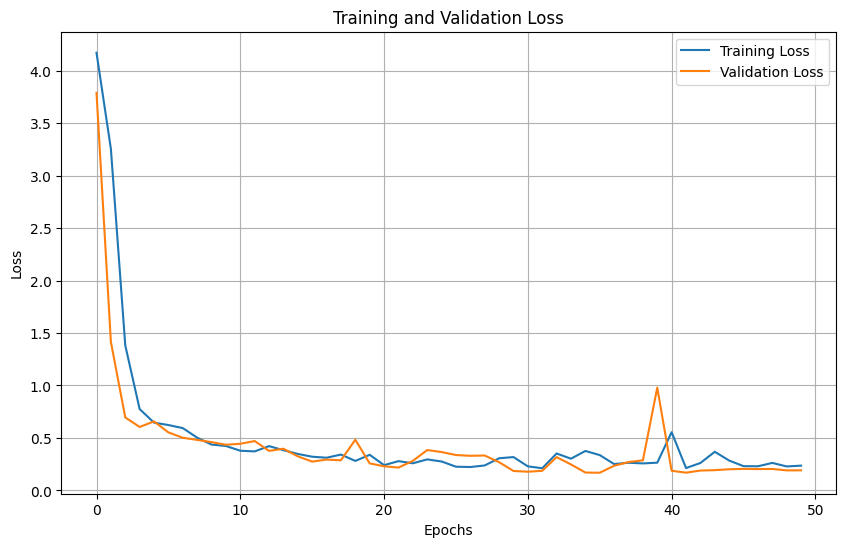

In [ ]:

# Plot training and validation loss
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


That's much better!

Let's save the model so someone can reproduce our work

In [ ]:

model.save('phalloidin_cnn_model.h5')
print("Model saved as 'phalloidin_cnn_model.h5'")



Model saved as 'phalloidin_cnn_model.h5'


In [ ]:
# # Load the saved model
# loaded_model = tf.keras.models.load_model('phalloidin_cnn_model.h5')
# print("Model loaded successfully"

#_ 5c _ Making Predictions


This model is doing well now, so let's apply it to our phalloidin image!

The model only predicts on one 101x101 square at a time, so we need to break down the image, process one chunk at a time, use the prediction score to fill in that chunk, stitch the colored prediction value chunks back together in a new image, and save our new picture which shows the prediction space

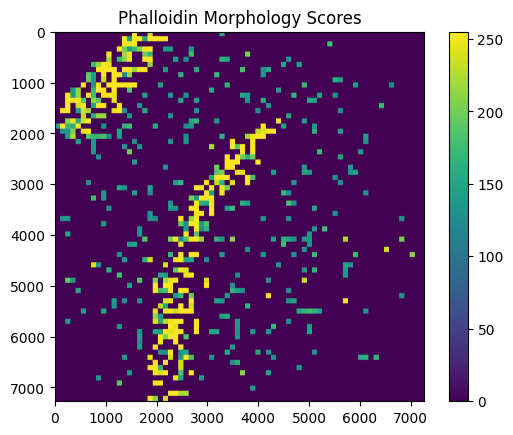

In [ ]:


def process_chunk(chunk, chunk_size, model):
    if chunk.shape == (chunk_size, chunk_size):  # Ensure chunk size is consistent
        chunk = chunk.reshape(1, chunk_size, chunk_size, 1) #make sure everything has the right dimensions
        score = model.predict(chunk, verbose=0)[0][0] #no verbosity! it will crash the notebook!
        return score
    return None

def process_image_in_chunks(image, chunk_size, model, num_threads=8):
    # Initialize the scores image
    scores_image = np.zeros((image.shape[0] // chunk_size, image.shape[1] // chunk_size))
    # get some help with the heavy lifting - still, this takes about ten minutes
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = []
        for i in range(0, image.shape[0], chunk_size):
            for j in range(0, image.shape[1], chunk_size):
                chunk = image[i:i + chunk_size, j:j + chunk_size]
                futures.append(executor.submit(process_chunk, chunk, chunk_size, model))
        #apply to the new image
        for index, future in enumerate(futures):
            i = (index // (image.shape[1] // chunk_size)) * chunk_size
            j = (index % (image.shape[1] // chunk_size)) * chunk_size
            score = future.result()
            if score is not None:
                scores_image[i // chunk_size, j // chunk_size] = score

    return scores_image

# Assume 'single_channel_image' is the phalloidin image
chunk_size = 101
scores_image = process_image_in_chunks(single_channel_image, chunk_size, model)

# Rescale the scores image to match the brightness setting of the histo slide for all positive predictions
score_image_rescaled = np.where(scores_image > 0.5, scores_image * 255, 0)
# zero out negative predictions so we don't create a lot of unecessary background noise
score_image_rescaled = np.clip(score_image_rescaled, 0, 255).astype(np.uint8)

# Resize the scores image to the original phalloidin image size
score_image_resized = np.repeat(np.repeat(score_image_rescaled, chunk_size, axis=0), chunk_size, axis=1)

# Display the resulting image
plt.imshow(score_image_resized, cmap='viridis')
plt.title('Phalloidin Morphology Scores')
plt.colorbar()
plt.show()

# Save the resulting image as a TIFF file
# tiff.imwrite('phalloidin_morphology_scores.tif', score_image_resized)
# print("Image saved as phalloidin_morphology_scores.tif")

Excellent!

Now let's combine our initial phalloidin image, our prediction space (plus a blank image for dimensionality matching) to our histo slide.

In [ ]:


#Get the images we made
phalloidin_image = single_channel_image
prediction_scores_image = score_image_resized

# Ensure all images have the same shape
assert phalloidin_image.shape == prediction_scores_image.shape

# Create a blank image
blank_image = np.zeros_like(prediction_scores_image)

# Combine the new channels into a single 3-dimensional image
new_channels = np.stack([phalloidin_image, prediction_scores_image, blank_image], axis=-1)

# Add slice dimension to new_channels to match img_array shape
new_channels = new_channels[..., np.newaxis, :]

print(f"Shape of new_channels: {new_channels.shape}")


# Load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

# Extract the image data array from the ImageContainer
img_array = img.data['image']
print(f"Shape of extracted image: {img_array.shape}")

# Ensure img_array has 4 dimensions
if img_array.ndim == 3:
    img_array = img_array[..., np.newaxis]

# Concatenate the combined new channels with the original image array
new_img_array = np.concatenate([img_array, new_channels], axis=-1)

print(f"New image shape: {new_img_array.shape}")

# Create a new DataArray with the new image array and dimension names
new_img_da = xr.DataArray(new_img_array, dims=["y", "x", "z", "channels"])

# Update the ImageContainer with the new DataArray
img.add_img(new_img_da, layer="image", copy=False)

Shape of new_channels: (7272, 7272, 1, 3)
Shape of extracted image: (7272, 7272, 1, 3)
New image shape: (7272, 7272, 1, 6)


Now let's see how the prediction values correlate with the image.

First, we will review the initial clusters, the phalloidin channel, and the morpho prediction space



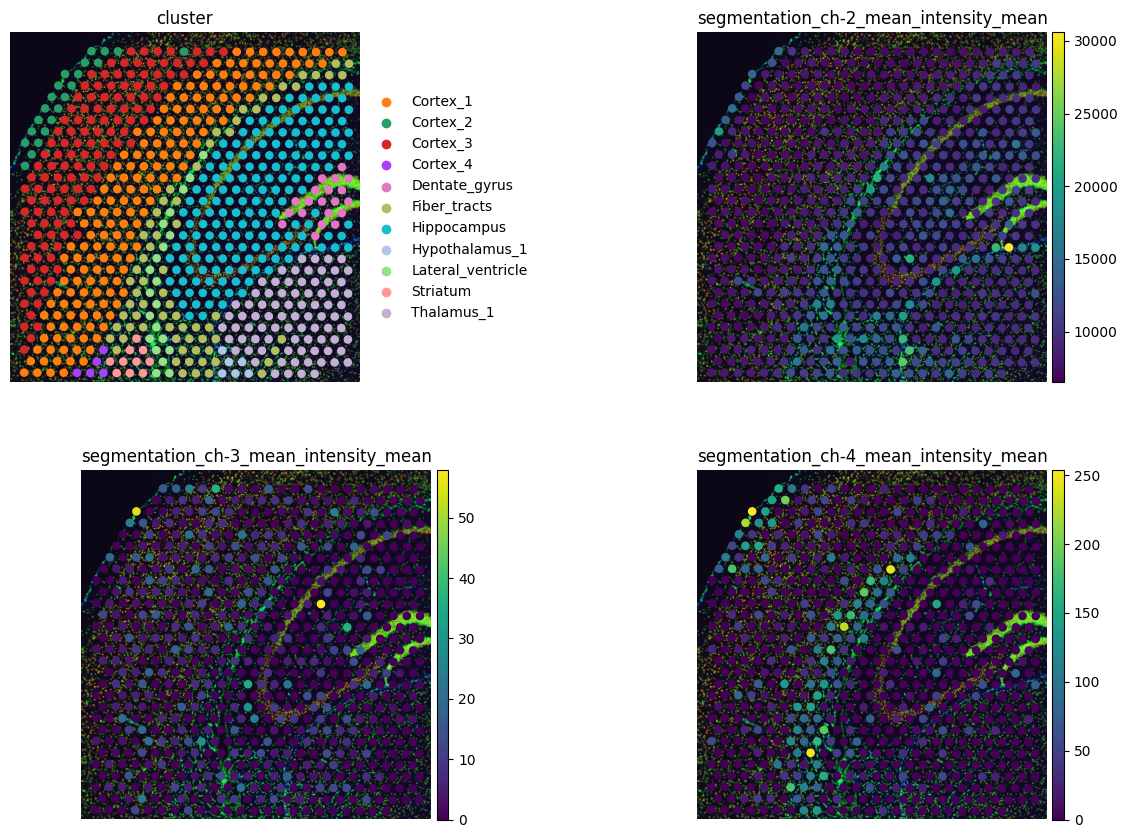

In [ ]:
#Now let's see how the prediction values correlate with the image
#First, we will review the initial clusters, the phalloidin channel, and the morpho prediction space

#The brightness of the phalloidin channel per spot (channel 3) is fairly consistent, but the morpho prediction score (channel 4)
#is heavily enriched along cortex 2 and fiber tracts.

#Glial positivity stain (channel 2) shows that there are some glial cells which are negative for the morpho prediction!
#These are located mostly at the bottom right of the slide.

#Segment the entire image
#We need to redo this because the new object with our three new channels never got segmented
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}

# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "cluster",
        "segmentation_ch-2_mean_intensity_mean",
        "segmentation_ch-3_mean_intensity_mean",
        "segmentation_ch-4_mean_intensity_mean",
    ],
    frameon=False,
    ncols=2,

)

The brightness of the phalloidin channel per spot (channel 3) is fairly consistent, but the morpho prediction score (channel 4) is heavily enriched along cortex 2 and fiber tracts.

Glial positivity stain (channel 2) shows that there are some glial cells which are negative for the morpho prediction! These are located mostly at the bottom right of the slide.

Now that we have things segmented, let's redo our subset selection again to focus on the glial subclusters in our new object.

Remember that we decided to threshold above mean channel 2 brightness 12000 to sub-cluster the glial cells.

This is still clustering based on transcriptomics

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


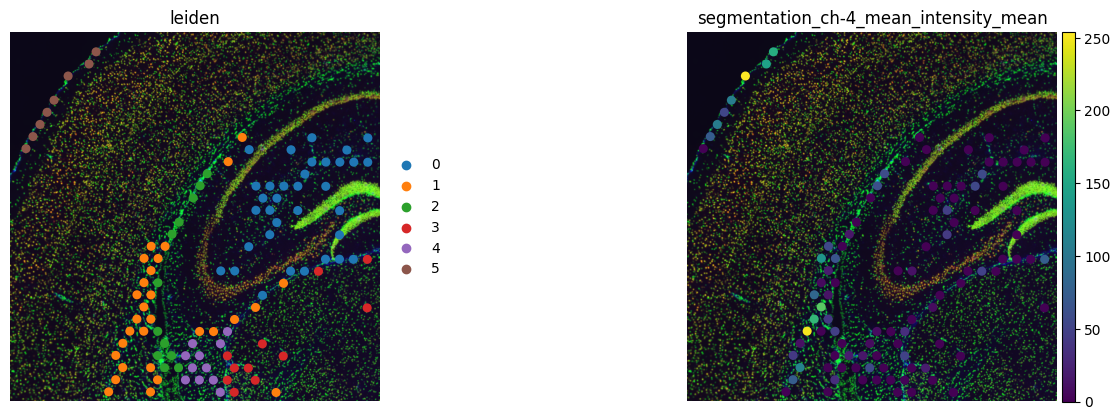

In [ ]:


# Create a copy of the AnnData object
adata_copy = adata.copy()

# Access the 'features_segmentation' layer
features_segmentation = adata_copy.obsm['features_segmentation']

# Convert to DataFrame for easier manipulation
features_df = pd.DataFrame(features_segmentation, index=adata_copy.obs.index)

# Access the desired column (assuming column 7 corresponds to "segmentation_ch-2_mean_intensity_mean")
channel_2_brightness = features_df.iloc[:, 7]

# Add the channel 2 brightness as a new column in the .obs attribute
adata_copy.obs['channel_2_brightness'] = channel_2_brightness

# Define the threshold value
brightness_threshold = 12000

# Subset the AnnData object for observations with channel 2 brightness above the threshold
subset_adata = adata_copy[adata_copy.obs['channel_2_brightness'] > brightness_threshold]

#Redo the subclustering

# Create a copy of the subset for safety
subset_adata2 = subset_adata.copy()

# Normalize the data
sc.pp.normalize_total(subset_adata2, target_sum=1e4)
sc.pp.log1p(subset_adata2)

# Find highly variable genes
sc.pp.highly_variable_genes(subset_adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Subset to highly variable genes
subset_adata3 = subset_adata2[:, subset_adata2.var.highly_variable]

# Scale the data
sc.pp.scale(subset_adata3, max_value=10)

# Compute the neighborhood graph
sc.pp.neighbors(subset_adata3, n_neighbors=10, n_pcs=40)

# Run the Leiden algorithm
sc.tl.leiden(subset_adata3, resolution=0.6)

# Alternatively, you can use the Louvain algorithm
# sc.tl.louvain(subset_adata, resolution=0.5)

# Compute UMAP for visualization
sc.tl.umap(subset_adata3)

# # Plot the UMAP with clusters
# sc.pl.umap(subset_adata3, color=['leiden'])  # Or replace 'leiden' with 'louvain' if using Louvain

# Remove the existing color palette for 'leiden' clusters
if 'leiden_colors' in subset_adata3.uns:
    subset_adata3.uns.pop('leiden_colors')


# Extract the segmentation features from the subset AnnData object
extracted_features = sq.pl.extract(subset_adata3, "features_segmentation")

# Plot the results and visualize the clusters
sq.pl.spatial_scatter(
    extracted_features,
    color=[
        "leiden",  # or 'louvain' depending on which clustering method you used
        "segmentation_ch-4_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

Let's instead cluster on the morphology prediction!

First, we will see how the positive predictions sub-cluster.

Later, we will give all negative predictions the same cluster label.

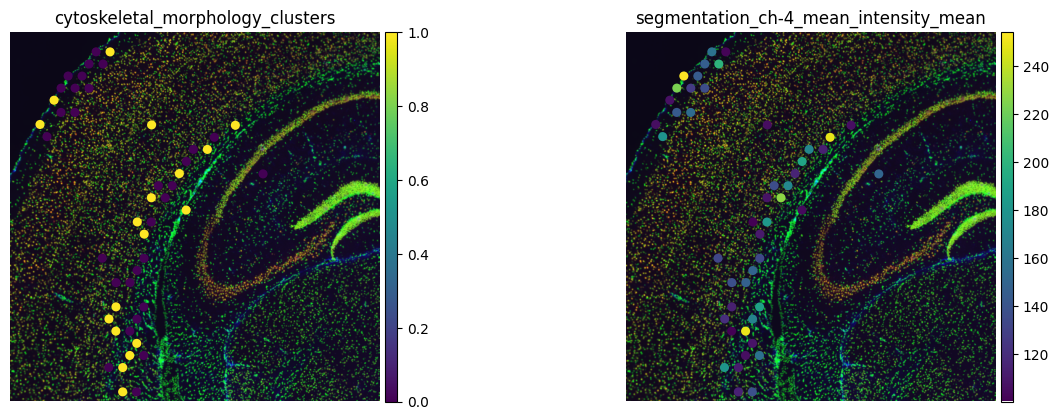

In [ ]:

# Copy the AnnData object
adata_copy = adata.copy()

# Access the 'features_segmentation' layer
features_segmentation = adata_copy.obsm['features_segmentation']

# Convert to DataFrame for easier manipulation
features_df = pd.DataFrame(features_segmentation, index=adata_copy.obs.index)

# Access the desired column for channel 4 mean intensity
channel_4_brightness = features_df['segmentation_ch-4_mean_intensity_mean']

#Subset to positive predictions only
# Add the channel 4 brightness as a new column in the .obs attribute
adata_copy.obs['segmentation_ch-4_mean_intensity_mean'] = channel_4_brightness

# Define the threshold value
brightness_threshold = 100

# Subset the AnnData object for observations with channel 4 brightness above the threshold
# subset_adata = adata_copy[adata_copy.obs['segmentation_ch-4_mean_intensity_mean'] > brightness_threshold]

# Subset the AnnData object for observations with channel 4 brightness above the threshold
subset_adata = adata_copy[adata_copy.obs['segmentation_ch-4_mean_intensity_mean'] > brightness_threshold].copy()

# Extract the channel 4 brightness values for the positive subset, because we are doing clustering outside the scanpy package
positive_brightness = subset_adata.obs['segmentation_ch-4_mean_intensity_mean'].values

#We need to do the leiden clustering outside of the andata object first, since scanpy/squidpy will always focus on the transcriptomic data

# Create a graph for fine-grained clustering
g = ig.Graph()
g.add_vertices(len(positive_brightness))
weights = np.array(positive_brightness)

# Create adjacency matrix with positive_brightness
threshold_distance = 1000
edges = []
weights = []
for i in range(len(positive_brightness)):
    for j in range(i + 1, len(positive_brightness)):
        distance = abs(positive_brightness[i] - positive_brightness[j])
        if distance < threshold_distance:
            edges.append((i, j))
            weights.append(1 / (1 + distance))

g.add_edges(edges)
g.es['weight'] = weights

# Set the resolution parameter - adjusting this controls granularity
resolution_parameter = 0.4

# Perform Leiden clustering
partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, weights=g.es['weight'], resolution_parameter=resolution_parameter)

# Extract fine-grained cluster labels
fine_grained_labels = np.array(partition.membership)


# Add the cluster labels to the AnnData object
subset_adata.obs['cytoskeletal_morphology_clusters'] = fine_grained_labels

# Visualization
sq.pl.spatial_scatter(
    subset_adata,
    color=[
        "cytoskeletal_morphology_clusters",
        "segmentation_ch-4_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)

Let's see which resolution parameter is best for this clustering.

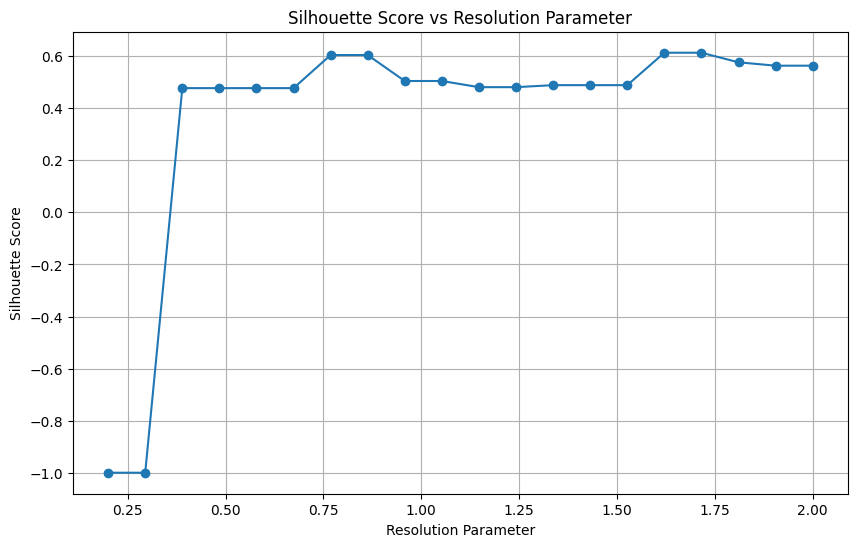

In [ ]:


# Define the resolution values
resolution_values = np.linspace(0.2, 2.0, 20)

# Initialize lists to store results
silhouette_scores = []

# Function to perform clustering and compute silhouette score
def compute_silhouette_score(resolution_parameter):
    # Create a graph for clustering
    g = ig.Graph()
    g.add_vertices(len(positive_brightness))
    weights = np.array(positive_brightness)

    # Create adjacency matrix with positive_brightness
    threshold_distance = 1000
    edges = []
    weights = []
    for i in range(len(positive_brightness)):
        for j in range(i + 1, len(positive_brightness)):
            distance = abs(positive_brightness[i] - positive_brightness[j])
            if distance < threshold_distance:
                edges.append((i, j))
                weights.append(1 / (1 + distance))

    g.add_edges(edges)
    g.es['weight'] = weights

    # Perform Leiden clustering with the given resolution parameter
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, weights=g.es['weight'], resolution_parameter=resolution_parameter)

    # Extract cluster labels
    labels = np.array(partition.membership)

    # Check the number of unique labels
    n_labels = len(np.unique(labels))

    # Compute silhouette score if the number of labels is valid
    if 1 < n_labels < len(labels):
        score = silhouette_score(positive_brightness.reshape(-1, 1), labels, metric='euclidean')
        return score
    else:
        return None

# Compute silhouette scores for each resolution value
for resolution in resolution_values:
    score = compute_silhouette_score(resolution)
    if score is not None:
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Use -1 to indicate an invalid score

# Plot the silhouette scores against resolution values
plt.figure(figsize=(10, 6))
plt.plot(resolution_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Resolution Parameter')
plt.xlabel('Resolution Parameter')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()



There are some choices which would give slightly higher metrics, but a resolution value of 0.4 seems good and reflects the ch4 mean intensity mean, which we know correlates with 0.5-0.75 prediction and 0.75-1 prediction values.

Let's continue with the value we chose.

#_ 5d _ Summarize Morphological Insights

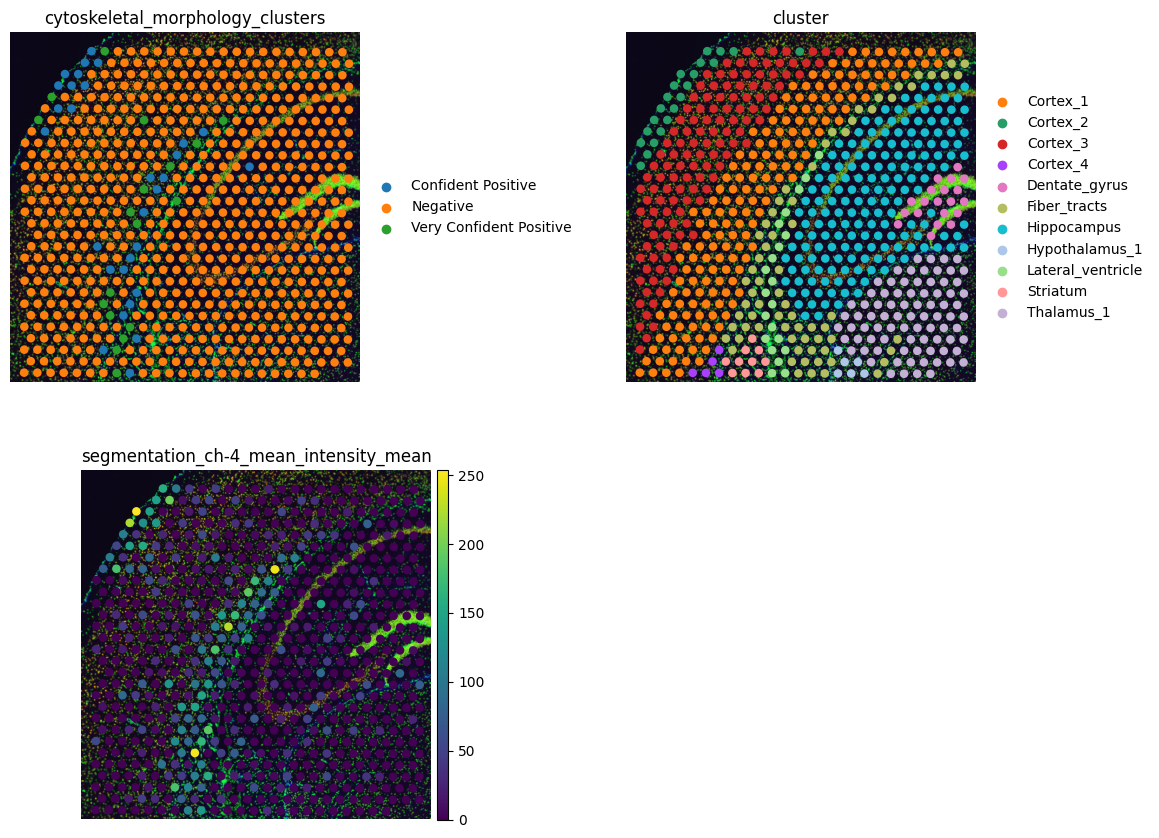

In [ ]:
# Create a full array for the fine-grained labels, initializing with 'Negative'
full_labels = np.full(len(adata_copy), 'Negative', dtype=object)

# Define the mapping for fine-grained clusters
label_mapping = {0: 'Confident Positive', 1: 'Very Confident Positive'}

# Fill in the fine-grained labels for the positive population
positive_indices = adata_copy.obs['segmentation_ch-4_mean_intensity_mean'] > brightness_threshold
fine_grained_clusters = subset_adata.obs['cytoskeletal_morphology_clusters'].map(label_mapping)
full_labels[positive_indices] = fine_grained_clusters.values

# Add the full labels back to the original AnnData object
adata_copy.obs['cytoskeletal_morphology_clusters'] = full_labels

# Visualization within AnnData object
sq.pl.spatial_scatter(
    adata_copy,
    color=[
        "cytoskeletal_morphology_clusters",
        "cluster",
        "segmentation_ch-4_mean_intensity_mean"
    ],
    frameon=False,
    ncols=2,
)


Putting this all together, we see that morphological information puts glial subclusters 1,2, and 5 together.

This is not something the transcriptomic data noticed - the transcriptomic data put clusters 0 and 5 together, and generally struggled to find strong support for meaningful separation.

The morphological data shows that glial cells in the cortex 2 and fiber tracts regions are phenotypically similar, even though the transcriptomic data doesn't call them out as being most similar.

This is interesting information for research - what is impacting those two regions of the brain?

The most important gene for the transcriptomic view was Ptgds, which inhibits platelet formation. But it seems that regardless of expression activity, fiber tract glial cells share the same phenotype as cortex 2 glial cells which expressed high levels of Ptgds. The treatment this pretend mouse received which increased Ptgds expression in cortex 2 also effected the fiber tract cells. This is important information for understanding the mechcanism of this pretend treatment.